In [40]:
import sys
import glob
import os
import pandas as pd
import matplotlib.pyplot as plt
import ee
import numpy as np
from scipy import stats
from datetime import datetime, timedelta

plt.rcParams['figure.figsize'] = [18,16]
ee.Initialize()

In [41]:
# Helpers 

In [42]:
def read_file(filename):
    with open(filename) as f:
        contents = f.readlines()

    data = []
    for line in contents:
        if line[0:1] == "#":
            continue
        else:
            data.append(line)

    headers = [x.replace("Soil Moisture Percent","smp").replace(" ","_") for x in data[0].split(",")]
    cols = [x.strip("\n").split(",") for x in data[1:]]

    df = pd.DataFrame(cols, columns = headers)
    
    return df

def get_site_lat_lons(site_num, stations_csv):
    df = pd.read_csv(stations_csv)
    site = df[df['site_name'].str.contains(site_no)]
    
    lat, lon = site['lat'].values, site['lon'].values
    return lat[0], lon[0]

In [43]:
# EE --> Numpy functions

In [44]:
def array_from_latlon(latlon_obj):
    res = latlon_obj.reduceRegion(reducer=ee.Reducer.toList(),geometry=area,maxPixels=1e8,scale=10)
    data = np.array((ee.Array(res.get("VV")).getInfo()))
    lats = np.array((ee.Array(res.get("latitude")).getInfo()))
    lons = np.array((ee.Array(res.get("longitude")).getInfo()))
    out = make_np_array(data, lats, lons)
    return out   

def array_from_latlon_ppt(latlon_obj):
    res = latlon_obj.reduceRegion(reducer=ee.Reducer.toList(),geometry=area,maxPixels=1e8,scale=10)
    data = np.array((ee.Array(res.get("ppt")).getInfo()))
    lats = np.array((ee.Array(res.get("latitude")).getInfo()))
    lons = np.array((ee.Array(res.get("longitude")).getInfo()))
    out = make_np_array(data, lats, lons)
    return out   

def make_np_array(data, lats, lons):
    # get data from df as arrays
    lons = np.array(lons)
    lats = np.array(lats)
    data = np.array(data) # Set var here 
                                              
    # get the unique coordinates
    uniqueLats = np.unique(lats)
    uniqueLons = np.unique(lons)

    # get number of columns and rows from coordinates
    ncols = len(uniqueLons)    
    nrows = len(uniqueLats)

    # determine pixelsizes
    ys = uniqueLats[1] - uniqueLats[0] 
    xs = uniqueLons[1] - uniqueLons[0]

    # create an array with dimensions of image
    arr = np.zeros([nrows, ncols], np.float32)

    # fill the array with values
    counter =0
    for y in range(0,len(arr),1):
        for x in range(0,len(arr[0]),1):
            if lats[counter] == uniqueLats[y] and lons[counter] == uniqueLons[x] and counter < len(lats)-1:
                counter+=1
                arr[len(uniqueLats)-1-y,x] = data[counter] # we start from lower left corner
    
    return arr

def get_ims_dates(ims_list):
    imlist = []
    imdates = []
    num_images = len(ims_list.getInfo())

    for i in range (1, num_images):
        latlon = ee.Image.pixelLonLat().addBands(ims_list.get(i))
        imlist.append(array_from_latlon(latlon))
        info_dict = ims.get(i).getInfo()
        date = info_dict['id']
        imdates.append(date)
    
    times = []
    for i in imdates:
        time_idx = i.find("T0")
        ymd = i[time_idx-8:time_idx]
        hms = i[time_idx+1:time_idx+7]
        times.append(datetime.strptime(ymd+hms, '%Y%m%d%H%M%S'))

    return imlist, times

def get_ims_dates_ppt(ims_list):
    imlist = []
    imdates = []
    num_images = len(ims_list.getInfo())

    for i in range (1, num_images):
        latlon = ee.Image.pixelLonLat().addBands(ims_list.get(i))
        imlist.append(array_from_latlon_ppt(latlon))
        info_dict = ims.get(i).getInfo()
        date = info_dict['id']
        imdates.append(date)
    
    times = []
    for i in imdates:
        time_idx = i.find("T0")
        ymd = i[time_idx-8:time_idx]
        hms = i[time_idx+1:time_idx+7]
        times.append(datetime.strptime(ymd+hms, '%Y%m%d%H%M%S'))

    return imlist, times


In [45]:
# Find files

In [46]:
csvs = glob.glob("*.csv")
txts = glob.glob("*.txt")
site_file = txts[0]
stations_csv = csvs[0]

In [47]:
# Extract soil moisture site data

In [48]:
site_no = ''.join(c for c in site_file if c.isdigit())
data = read_file(site_file)
lat, lon = get_site_lat_lons(site_no,stations_csv)

In [49]:
# Setup ee Objects

In [50]:
buffer_size = 50 # meters

In [51]:
pt = ee.Geometry.Point([lon, lat])
area = pt.buffer(buffer_size)

In [52]:
# Set the RS products to be queried, sort from oldest im first

In [53]:
collection = ee.ImageCollection('COPERNICUS/S1_GRD').filterBounds(pt).filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')).filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING')).select('VV')
col = collection.filterDate('2014-10-03','2018-10-03')
t = col.sort('system:time_start')
ims = t.toList(t.size())

In [54]:
# get the ims and sort out the dates to match

In [55]:
s1dat, dates = get_ims_dates(ims)

In [56]:
data['Date'] =  pd.to_datetime(data['Date'], format='%Y%m%d %H:%M')
data.set_index('Date', inplace=True)

In [57]:
# Round each startdate to the nearest hour, grab the data that matches that hour 
rzsm = []
ssm = []

for i in dates:
    start = i.replace(second=0, microsecond=0, minute=0, hour=i.hour)+timedelta(hours=i.minute//30)
    df = pd.DataFrame(data.loc[start]).T.astype(np.float)
    rzsm.append(df[df.columns[-1]].values)
    ssm.append(df[df.columns[-3]].values)
    

In [58]:
rzsm = [x for l in rzsm for x in l]
ssms = [x for l in ssm for x in l]

In [59]:
mean_sigmas = []

for i in s1dat:
    mean_sigmas.append(np.mean(i))

In [60]:
x = np.array(mean_sigmas)
x = x.reshape(x.shape[0])
y = np.array(rzsm)
y = y.reshape(y.shape[0])
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

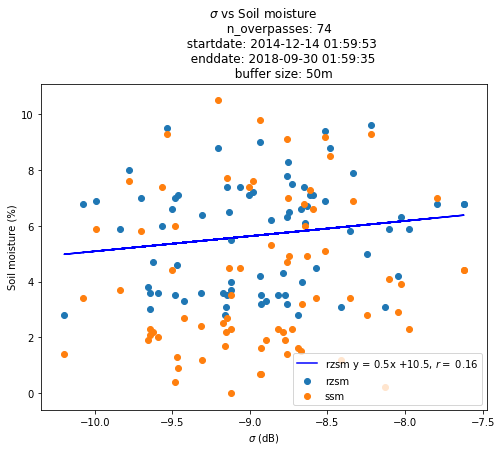

In [61]:
plt.figure(figsize=(8,6))

plt.title('''$\sigma$ vs Soil moisture 
          n_overpasses: {}  
          startdate: {} 
          enddate: {}
          buffer size: {}m'''.format(len(dates), dates[0], dates[-1], buffer_size))

plt.xlabel("Backscatter ($\sigma$), dB")
plt.scatter(mean_sigmas, rzsm, label = 'rzsm')
plt.scatter(mean_sigmas, ssm, label = 'ssm')
plt.plot(x, intercept + slope*x, 'blue', label='rzsm y = {}x +{}, $r =$ {}'.format(round(slope,1), round(intercept,1), round(r_value,2)))
plt.xlabel("$\sigma$ (dB)")
plt.ylabel("Soil moisture (%)")
plt.legend()
plt.show()

In [62]:
# as a timeseries

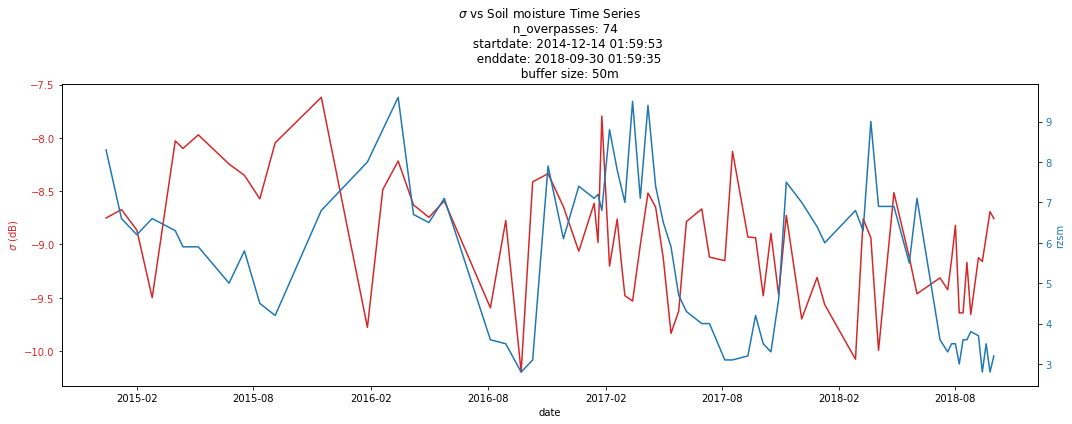

In [63]:
fig, ax1 = plt.subplots(figsize=(15,6))

plt.title('''$\sigma$ vs Soil moisture Time Series
          n_overpasses: {}  
          startdate: {} 
          enddate: {}
          buffer size: {}m'''.format(len(dates), dates[0], dates[-1], buffer_size))

color = 'tab:red'
ax1.set_xlabel('date')
ax1.set_ylabel("$\sigma$ (dB)", color=color)
ax1.plot(dates, mean_sigmas, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('rzsm', color=color)  
ax2.plot(dates,rzsm,color = color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout() 

plt.show()

In [64]:
# remove the days with high preceding rainfall 

In [65]:
imageCollection = ee.ImageCollection("OREGONSTATE/PRISM/AN81d").filterBounds(area)

In [66]:
def filter_date(product,y,m,d):
    start = ee.Date.fromYMD(y,m,d).advance(-1, "day")
    end = ee.Date.fromYMD(y,m,d)
    end = ee.Date.fromYMD(y,m,d)
    prod = product.filterDate(start, end).sort('system:time_start', False).select("ppt")
    return prod

def get_2day_precip(latlon_obj):
    res = latlon_obj.reduceRegion(reducer=ee.Reducer.sum(),geometry=area,scale=10)
    data = np.array((ee.Array(res.get("ppt")).getInfo()))
    out = np.array(data)
    return out 

In [67]:
rainfall = []

for i,x in enumerate(dates):
    y,m,d = dates[i].year, dates[i].month, dates[i].day
    t = filter_date(imageCollection, y, m, d).sum()
    precip_total = get_2day_precip(t)
    rainfall.append(precip_total)

In [68]:
fdf = pd.DataFrame([dates, mean_sigmas, rzsm, rainfall])

In [69]:
fdf = fdf.T
fdf.columns = (['date', "sigma", "rzsm", "rainfall"])

In [70]:
mask=(fdf['rainfall'] < 0.1)
asdf=fdf[mask]

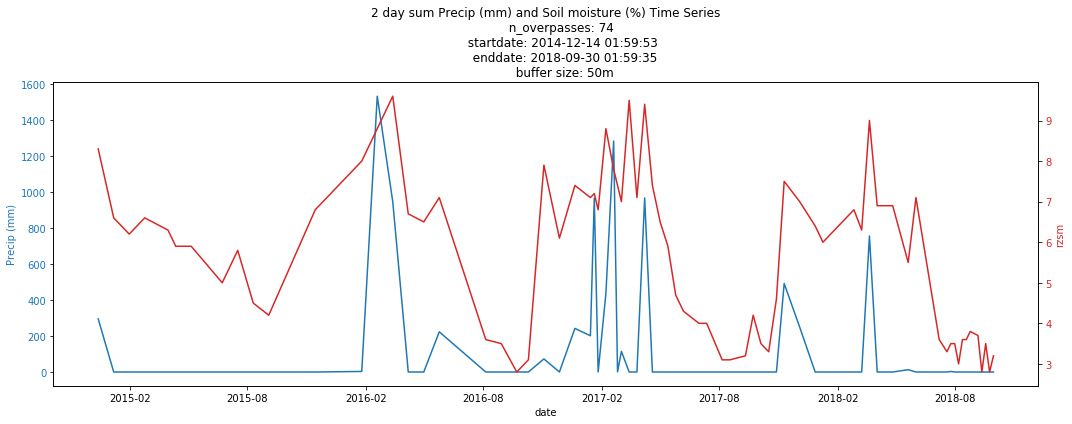

In [71]:
fig, ax1 = plt.subplots(figsize=(15,6))

plt.title('''2 day sum Precip (mm) and Soil moisture (%) Time Series
          n_overpasses: {}  
          startdate: {} 
          enddate: {}
          buffer size: {}m'''.format(len(dates), dates[0], dates[-1], buffer_size))

color = 'tab:blue'
ax1.set_xlabel('date')
ax1.set_ylabel("Precip (mm)", color=color)
ax1.plot(dates, rainfall, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('rzsm', color=color)  
ax2.plot(dates,rzsm,color = color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout() 

plt.show()

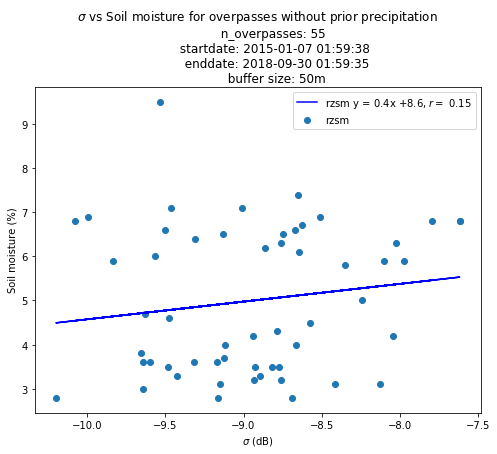

In [72]:
# Plot linear fit of sigma vs SM
x = np.array(asdf['sigma'])
x = x.reshape(x.shape[0]).astype(np.float32)
y = np.array(asdf['rzsm'])
y = y.reshape(y.shape[0]).astype(np.float32)

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

plt.figure(figsize=(8,6))

plt.title('''$\sigma$ vs Soil moisture for overpasses without prior precipitation
          n_overpasses: {}  
          startdate: {} 
          enddate: {}
          buffer size: {}m'''.format(len(asdf), asdf['date'].min(), asdf['date'].max(), buffer_size))

plt.xlabel("Backscatter ($\sigma$), dB")
plt.scatter(asdf['sigma'],asdf['rzsm'], label = "rzsm")
# plt.scatter(mean_sigmas, ssm, label = 'ssm')
plt.plot(x, intercept + slope*x, 'blue', label='rzsm y = {}x +{}, $r =$ {}'.format(round(slope,1), round(intercept,1), round(r_value,2)))
plt.xlabel("$\sigma$ (dB)")
plt.ylabel("Soil moisture (%)")
plt.legend()
plt.show()

In [73]:
# Let's test with 4 day precip accumulation

imageCollection = ee.ImageCollection("OREGONSTATE/PRISM/AN81d").filterBounds(area)

def filter_date(product,y,m,d):
    start = ee.Date.fromYMD(y,m,d).advance(-4, "day")
    end = ee.Date.fromYMD(y,m,d)
    end = ee.Date.fromYMD(y,m,d)
    prod = product.filterDate(start, end).sort('system:time_start', False).select("ppt")
    return prod

def get_2day_precip(latlon_obj):
    res = latlon_obj.reduceRegion(reducer=ee.Reducer.sum(),geometry=area,scale=10)
    data = np.array((ee.Array(res.get("ppt")).getInfo()))
    out = np.array(data)
    return out 

rainfall = []

for i,x in enumerate(dates):
    y,m,d = dates[i].year, dates[i].month, dates[i].day
    t = filter_date(imageCollection, y, m, d).sum()
    precip_total = get_2day_precip(t)
    rainfall.append(precip_total)
    

In [74]:
fdf = pd.DataFrame([dates, mean_sigmas, rzsm, rainfall])
fdf = fdf.T
fdf.columns = (['date', "sigma", "rzsm", "rainfall"])
mask=(fdf['rainfall'] < 0.1)
asdf=fdf[mask]

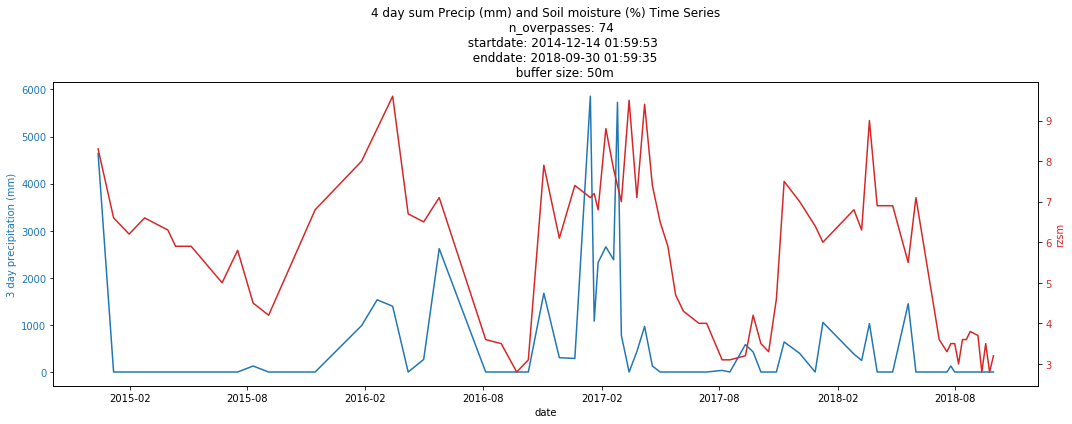

In [75]:
fig, ax1 = plt.subplots(figsize=(15,6))

plt.title('''4 day sum Precip (mm) and Soil moisture (%) Time Series
          n_overpasses: {}  
          startdate: {} 
          enddate: {}
          buffer size: {}m'''.format(len(dates), dates[0], dates[-1], buffer_size))

color = 'tab:blue'
ax1.set_xlabel('date')
ax1.set_ylabel("3 day precipitation (mm)", color=color)
ax1.plot(dates, rainfall, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('rzsm', color=color)  
ax2.plot(dates,rzsm,color = color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout() 

plt.show()

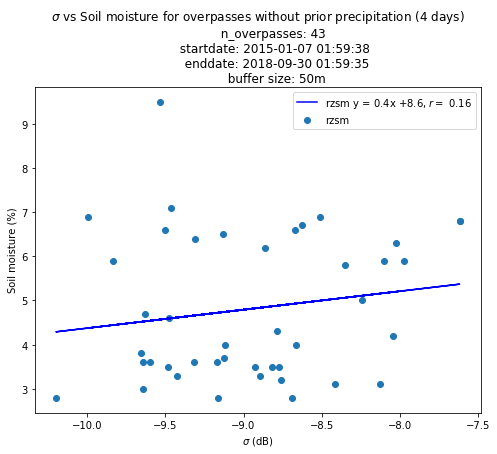

In [76]:
# Plot linear fit of sigma vs SM
x = np.array(asdf['sigma'])
x = x.reshape(x.shape[0]).astype(np.float32)
y = np.array(asdf['rzsm'])
y = y.reshape(y.shape[0]).astype(np.float32)

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

plt.figure(figsize=(8,6))

plt.title('''$\sigma$ vs Soil moisture for overpasses without prior precipitation (4 days)
          n_overpasses: {}  
          startdate: {} 
          enddate: {}
          buffer size: {}m'''.format(len(asdf), asdf['date'].min(), asdf['date'].max(), buffer_size))

plt.xlabel("Backscatter ($\sigma$), dB")
plt.scatter(asdf['sigma'],asdf['rzsm'], label = "rzsm")
# plt.scatter(mean_sigmas, ssm, label = 'ssm')
plt.plot(x, intercept + slope*x, 'blue', label='rzsm y = {}x +{}, $r =$ {}'.format(round(slope,1), round(intercept,1), round(r_value,2)))
plt.xlabel("$\sigma$ (dB)")
plt.ylabel("Soil moisture (%)")
plt.legend()
plt.show()